In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import false
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv("Quarterly-train.csv")
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V858,V859,V860,V861,V862,V863,V864,V865,V866,V867
0,Q1,7407.412314,7528.566074,7374.709225,7395.514848,7654.007989,7686.847835,7578.190743,7904.376716,7744.049254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q2,7552.454619,7541.774571,7466.568336,7550.333354,8067.131522,8063.701017,7901.029312,8155.387316,8031.010328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q3,8463.842193,8366.102309,8269.502192,8256.985325,8726.917647,8733.243591,8664.260087,8717.394568,8662.139727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q4,8498.941194,8409.926442,8391.441381,8292.860310,8798.521118,8753.990355,8740.062556,8695.540651,8627.447488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q5,1835.000000,2322.000000,3059.000000,1883.000000,1896.000000,2060.000000,2764.000000,1743.000000,1561.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Le dataset M4 est fourni en format wide : chaque colonne correspond à une série temporelle distincte. L’analyse est réalisée sur une seule série (Q1), conformément aux recommandations du cours.

Une ligne = une série

Une colonne = l’évolution dans le temps


Une série temporelle est une suite de valeurs d’une même variable observée à différents instants.

# Analyse

## 1-Preparation de données

Il est nécessaire de passer la table en format long pour pouvoir appliquer les algorithmes d'analyse.

In [2]:
data_clean = data.melt(id_vars='V1', var_name='V', value_name='VALUE')

data_clean['TIME'] = data_clean['V'].str[1:].astype(int) -1

data_clean = data_clean.rename(columns={'V1': 'ID'})

data_clean = data_clean.dropna(subset=['VALUE'])

data_clean = data_clean.sort_values(['ID', 'TIME'])

data_clean['TIME'] = data_clean.groupby('ID').cumcount() + 1

data_clean = data_clean[['ID', 'TIME', 'VALUE']].reset_index(drop=True)

print(data_clean.head(10))


   ID  TIME        VALUE
0  Q1     1  7407.412314
1  Q1     2  7528.566074
2  Q1     3  7374.709225
3  Q1     4  7395.514848
4  Q1     5  7654.007989
5  Q1     6  7686.847835
6  Q1     7  7578.190743
7  Q1     8  7904.376716
8  Q1     9  7744.049254
9  Q1    10  7889.909013


In [3]:
data_clean.shape

(2214108, 3)

On choisit la première série à analyser

In [4]:
first_quarterly = data_clean[data_clean['ID'] == data_clean['ID'].unique()[0]]
serie = first_quarterly["VALUE"]

In [5]:
serie.head()

0    7407.412314
1    7528.566074
2    7374.709225
3    7395.514848
4    7654.007989
Name: VALUE, dtype: float64

In [6]:
serie.info()

<class 'pandas.core.series.Series'>
Index: 25 entries, 0 to 24
Series name: VALUE
Non-Null Count  Dtype  
--------------  -----  
25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [7]:
serie.dtype

dtype('float64')

### Importation des données de test

Nous importons maintenant les données de tests fournies et comme plus tot nous transformons le format wide en long

In [8]:
test_data = pd.read_csv("Quarterly-test.csv")

In [9]:
data_clean_test = test_data.melt(id_vars='V1', var_name='V', value_name='VALUE')

data_clean_test['TIME'] = data_clean_test['V'].str[1:].astype(int) -1

data_clean_test = data_clean_test.rename(columns={'V1': 'ID'})

data_clean_test = data_clean_test.dropna(subset=['VALUE'])

data_clean_test = data_clean_test.sort_values(['ID', 'TIME'])

data_clean_test['TIME'] = data_clean_test.groupby('ID').cumcount() + 1

data_clean_test = data_clean_test[['ID', 'TIME', 'VALUE']].reset_index(drop=True)

print(data_clean_test.head(10))

    ID  TIME        VALUE
0   Q1     1  6790.643698
1   Q1     2  6598.952202
2   Q1     3  6608.527173
3   Q1     4  6765.914014
4   Q1     5  6992.949003
5   Q1     6  6931.539000
6   Q1     7  7161.240869
7   Q1     8  6981.304105
8  Q10     1  2524.500000
9  Q10     2  2538.000000


Il y a bien 0 valeur nulle dans les données de test

In [10]:
data_clean_test.isna().sum()

ID       0
TIME     0
VALUE    0
dtype: int64

Et il y a bien autant de séries de test que de séries d'entrainement

In [11]:
data_clean_test.groupby("ID").size().describe()
data_clean.groupby("ID").size().describe()

count    24000.000000
mean        92.254500
std         51.129507
min         16.000000
25%         62.000000
50%         88.000000
75%        115.000000
max        866.000000
dtype: float64

## 2 Creation de l'index trimestriel

Notre série n'a pas d'index ainsi en partant de l'information dans m4_info.csv, nous savons que la première série commence en 2005 et que l'interval est trimestriel.
Nous créons donc un index qui commence au premier trimestre de 2005 et dont la frequence est trimestrielle.

In [12]:
serie.index = pd.period_range(
    start = "2005Q1",
    periods = len(serie),
    freq = "Q"
)

In [13]:
serie.head()

2005Q1    7407.412314
2005Q2    7528.566074
2005Q3    7374.709225
2005Q4    7395.514848
2006Q1    7654.007989
Freq: Q-DEC, Name: VALUE, dtype: float64

In [14]:
serie.index

PeriodIndex(['2005Q1', '2005Q2', '2005Q3', '2005Q4', '2006Q1', '2006Q2',
             '2006Q3', '2006Q4', '2007Q1', '2007Q2', '2007Q3', '2007Q4',
             '2008Q1', '2008Q2', '2008Q3', '2008Q4', '2009Q1', '2009Q2',
             '2009Q3', '2009Q4', '2010Q1', '2010Q2', '2010Q3', '2010Q4',
             '2011Q1'],
            dtype='period[Q-DEC]')

In [15]:
serie.shape

(25,)

In [16]:
serie.head(10)

2005Q1    7407.412314
2005Q2    7528.566074
2005Q3    7374.709225
2005Q4    7395.514848
2006Q1    7654.007989
2006Q2    7686.847835
2006Q3    7578.190743
2006Q4    7904.376716
2007Q1    7744.049254
2007Q2    7889.909013
Freq: Q-DEC, Name: VALUE, dtype: float64

## 3 Visualisation de la serie

Nous pouvons maintenant commencer à visualiser la série.

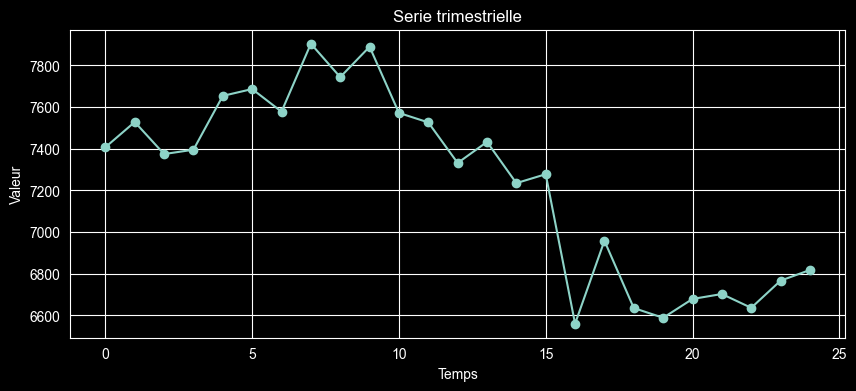

In [17]:
plt.figure(figsize=(10,4))
plt.plot(serie.values, marker='o')
plt.title("Serie trimestrielle")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

La série présente une tendance diminutive, mais pas de saisonnalité clairement identifiable.

In [18]:
print("Nombre total d'observations :", len(serie))

Nombre total d'observations : 25


## 4 Decomposition saisonière

Nous allons maintenant décomposer la série à l'aide de la fonction seasonal_decompose

<Figure size 1200x800 with 0 Axes>

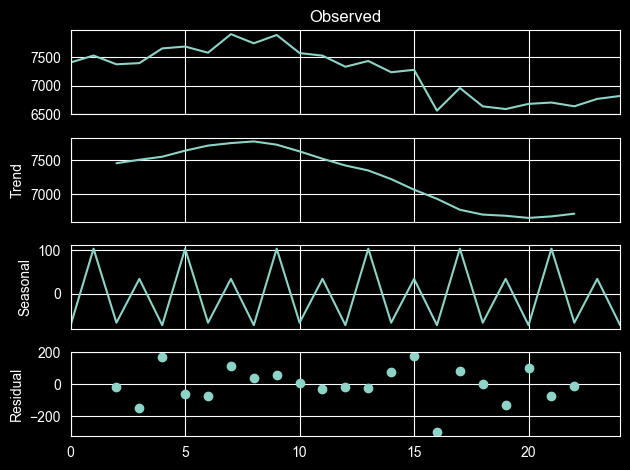

In [19]:
seasons = seasonal_decompose(serie.values, model='additive', period=4)

plt.figure(figsize=(12, 8))
seasons.plot()
plt.show()

Nous observons comme précédemment que la série a une tendance diminutive.

Nous observons également que notre série à une saisonnalité évidente toutes les 4 mesures ce qui parait logique que les résultats se ressemblent chaque année.

## 5 Test de stationnarité (ADF), ACF et PACF

In [20]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(serie)

# H₀ : la série n’est pas stationnaire

# H₁ : la série est stationnaire

In [21]:
print("ADF Statistic :", result[0])
print("p-value       :", result[1])


ADF Statistic : -0.4637341550076648
p-value       : 0.8989013636938894


Avec une p-value de 0.89 au test ADF, ce qui est plus grand que 0.05, nous pouvons refuser l'hypothèse 0 et donc determiner que notre série est stationnaire.

Étant donné que la série est stationnaire il est nécessaire de faire une différencier la série pour permettre des résultats non biaisés par les algorithmes suivants

In [22]:
serie_stationnaire = serie.diff().dropna()

from statsmodels.tsa.stattools import adfuller
result = adfuller(serie_stationnaire)

print("ADF:", result[0])
print("p-value:", result[1])


ADF: -8.192076238131763
p-value: 7.620240487352568e-13


Maintenant que nous avons effectué la différenciation notre série le test ADF nous retourne une p-value inférieur à 0.05.

Nous allons maintenant observer les graphes ACF et PACF afin de trouver les paramètres ARIMA optimaux.

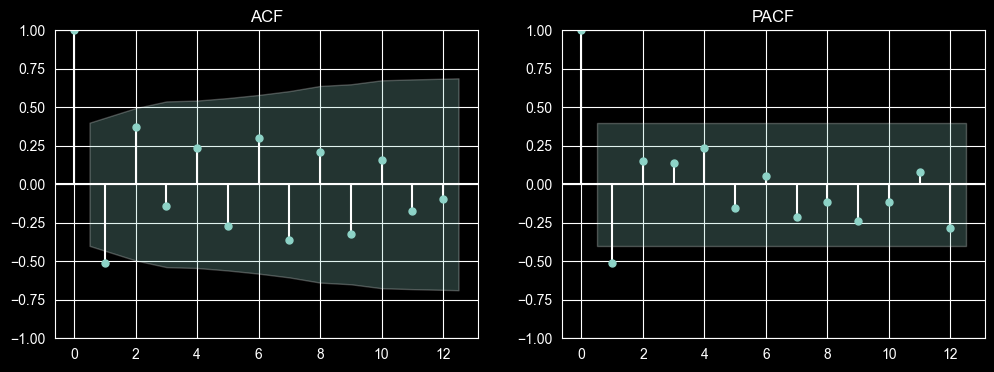

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

plot_acf(serie_stationnaire, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(serie_stationnaire, ax=axes[1], method="ywm")
axes[1].set_title("PACF")

plt.show()


Le graphe ACF nous permet de visualiser le paramètre optimal de q pour ARIMA.
Pour cela il faut obeserver le moment ou la valeur passe de l'autre coté de la ligne soit 1.

De même pour PACF qui nous permet de trouver le paramètre p.

ADF quand a lui nous à permis de trouver le paramètre d qui correspond au nombre de différenciation à faire pour atteindre la stationnarité.

## 6 Stabilité des cycles saisonniers

C:\Users\Abdallah Toumji\AppData\Local\Temp\ipykernel_12952\2348974061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1


<Axes: title={'center': 'VALUE'}, xlabel='Quarter_Cycle'>

<Figure size 1000x600 with 0 Axes>

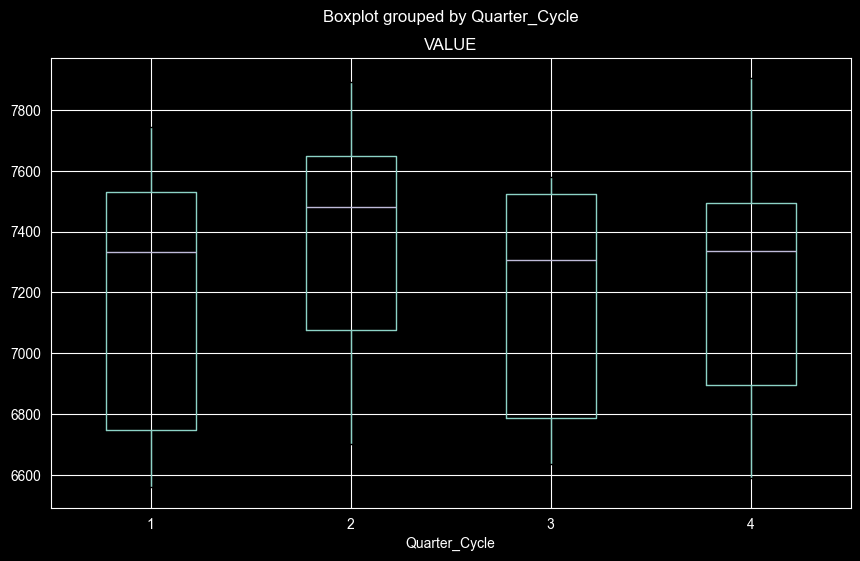

In [24]:
first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1
plt.figure(figsize=(10, 6))

first_quarterly.boxplot(column='VALUE', by='Quarter_Cycle', figsize=(10, 6))

Ce boxplot nous permet de voir la stabilité des cycles saisonniers.

On peut voir que le deuxième quartile est plus grand que le troisième ce qui suit ce que l'on a vu précédemment d'une saisonnalité forte avec une tendance décroissante.

# Implementation

## Définition des 100 séries de test

Nous allons tout d'abord définir les 100 séries sur lesquelles nous allons tester nos algorithmes afin d'avoir les mêmes pour tous.

In [25]:
all_ids = data_clean['ID'].unique()
np.random.seed(42)
ids_100 = np.random.choice(all_ids, size=100, replace=False)

## Métriques de précision

Nous allons d'abord définir nos méthodes de tests, SMAPE comme demandé pour le projet et MASE afin de savoir s'il y a une utilité à utiliser le modèle plutôt qu'un modèle naif.

In [26]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

# MASE (m=4 pour Quarterly) : compare la MAE du modèle à un naïf saisonnier (lag 4)
# -> naïf saisonnier : y_t ≈ y_{t-4} (même trimestre de l'année précédente)
def mase(y_true, y_pred, y_train, m=4):
    y_true  = np.asarray(y_true, dtype=float)
    y_pred  = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    # Il faut au moins m+1 points pour calculer le naïf saisonnier
    if len(y_train) <= m:
        return np.nan

    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_train[m:] - y_train[:-m]))

    return mae_model / mae_naive if mae_naive != 0 else np.nan


## ARIMA

Après avoir utilisé ARIMA sur une seule série et avoir bien compris son fonctionnement nous avons fait des recherches sur le moyen d'automatiser le processus de lecture de graphe afin d'utiliser ARIMA sur 100 séries.

Nous avons donc trouvé la fonction auto_arima de pmdarima qui permet de calculer automatiquement les paramètre d'ARIMA, cette fonction nous permettra également plus tard de faire SARIMA.

On précise bien le paramètre seasonal à False pour ne pas utiliser SARIMA.

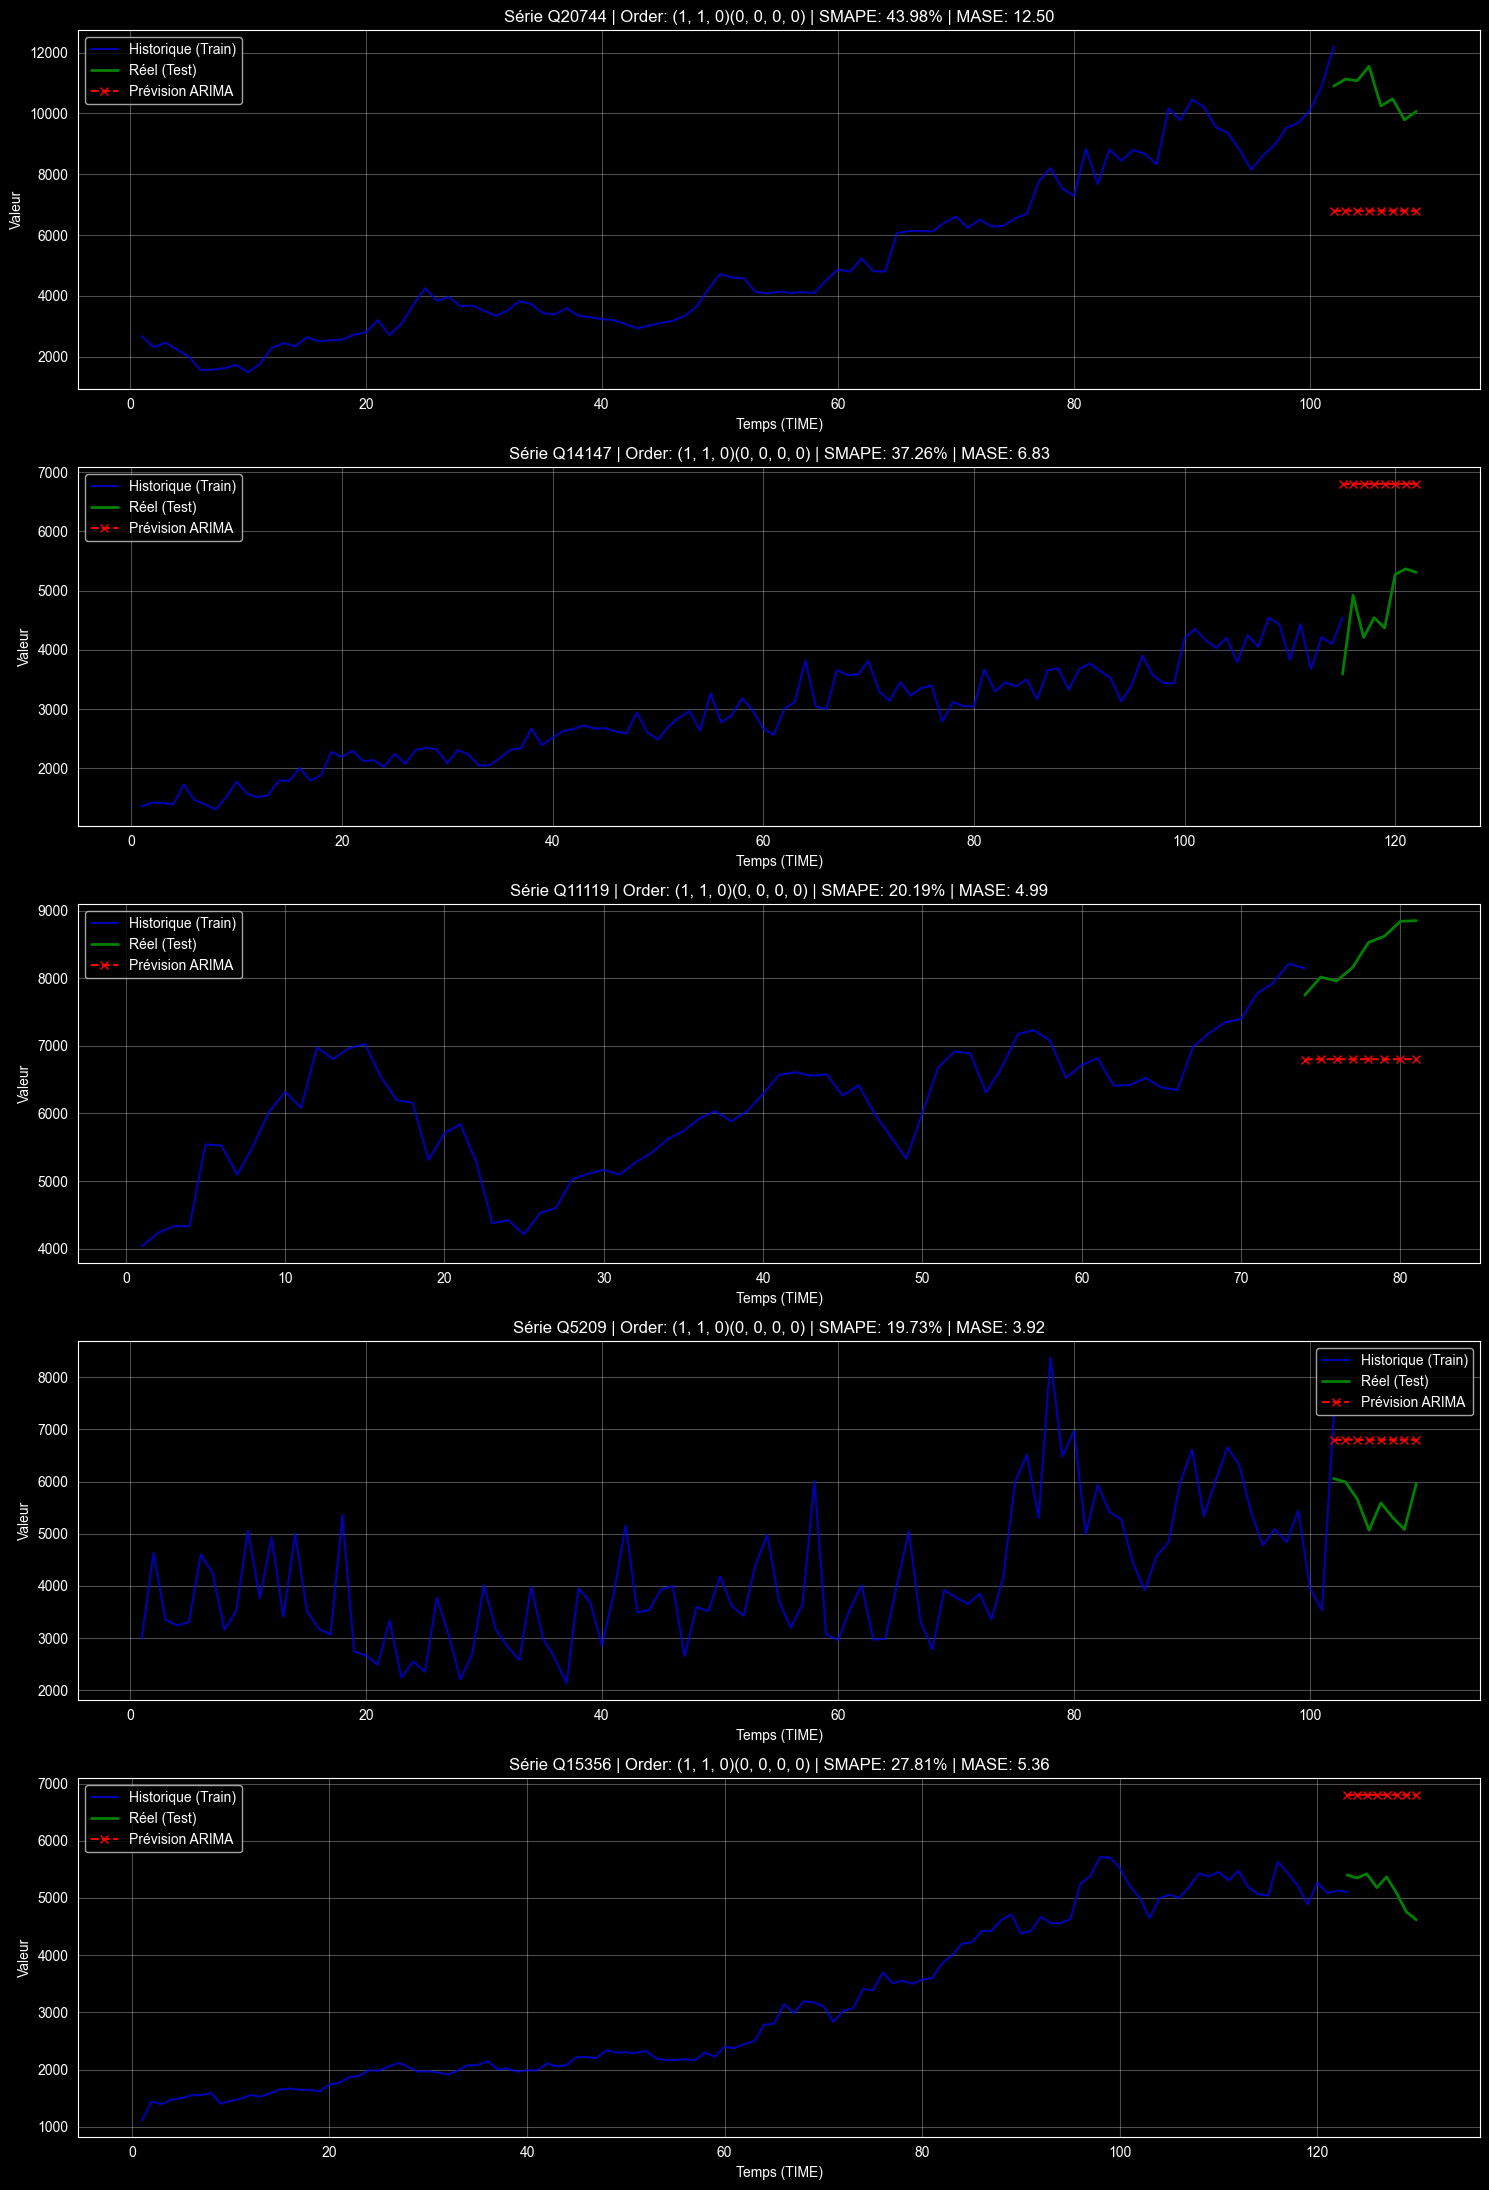

In [27]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

results = []
example_ids = np.random.choice(ids_100, size=5, replace=False)
fig, axes_list = plt.subplots(5, 1, figsize=(15, 22))
ax_map = {sid: ax for sid, ax in zip(example_ids, axes_list)}

for serie_id in ids_100:
    tr = data_clean[data_clean['ID'] == serie_id].sort_values("TIME")
    serie_train = tr['VALUE']
    x_train = tr['TIME']

    te = data_clean_test[data_clean_test['ID'] == serie_id].sort_values("TIME")
    y_test = te["VALUE"]
    x_test = te["TIME"]


    model_auto = auto_arima(serie,
                            seasonal=False, m=4, stepwise=True, suppress_warnings=True, error_action="ignore")

    p, d, q = model_auto.order

    y_pred = model_auto.predict(n_periods=len(y_test))
    sm = smape(y_test, y_pred)
    ms = mase(y_test, y_pred, serie)

    results.append({
        "ID": serie_id,
        "order": model_auto.order,
        "AIC": model_auto.aic(),
        "seasonal_order": model_auto.seasonal_order,
        "SMAPE": sm,
        "MASE": ms
    })

    if serie_id in example_ids:
            ax = ax_map[serie_id]
            ax.plot(x_train, serie_train, label="Historique (Train)", color="blue", alpha=0.7)
            ax.plot(range(len(x_train), len(x_train)+len(y_test)), y_test, label="Réel (Test)", color="green", linewidth=2)
            ax.plot(range(len(x_train), len(x_train)+len(y_pred)), y_pred, label="Prévision ARIMA", color="red", linestyle="--", marker='x')

            ax.set_title(f"Série {serie_id} | Order: {model_auto.order}{model_auto.seasonal_order} | SMAPE: {sm:.2f}% | MASE: {ms:.2f}")
            ax.set_xlabel("Temps (TIME)")
            ax.set_ylabel("Valeur")
            ax.legend()
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
results_df = pd.DataFrame(results)
results_df.head()

,ID,order,AIC,seasonal_order,SMAPE,MASE
0,Q12799,"(1, 1, 0)",328.036426,"(0, 0, 0, 0)",31.557889,8.273261
1,Q5209,"(1, 1, 0)",328.036426,"(0, 0, 0, 0)",19.727623,3.923281
2,Q4122,"(1, 1, 0)",328.036426,"(0, 0, 0, 0)",118.528089,16.413707
3,Q7704,"(1, 1, 0)",328.036426,"(0, 0, 0, 0)",99.279995,14.625777
4,Q7118,"(1, 1, 0)",328.036426,"(0, 0, 0, 0)",42.751224,7.602004


In [29]:
print(f"SMAPE global ARIMA : {results_df['SMAPE'].mean()}")
print(f"MASE global ARIMA : {results_df['MASE'].mean()}")

SMAPE global ARIMA : 68.86531123288859
MASE global ARIMA : 13.506853537118923


### SARIMA

En utilisant la même fonction que précédemment on applique SARIMA sur nos séries.

On précise également un p et d de départ sinon en essayant d'optimiser l'AIC auto ARIMA n'utilise pas la saisonnalité, de cette manière on le force à utiliser la saisonnalité.

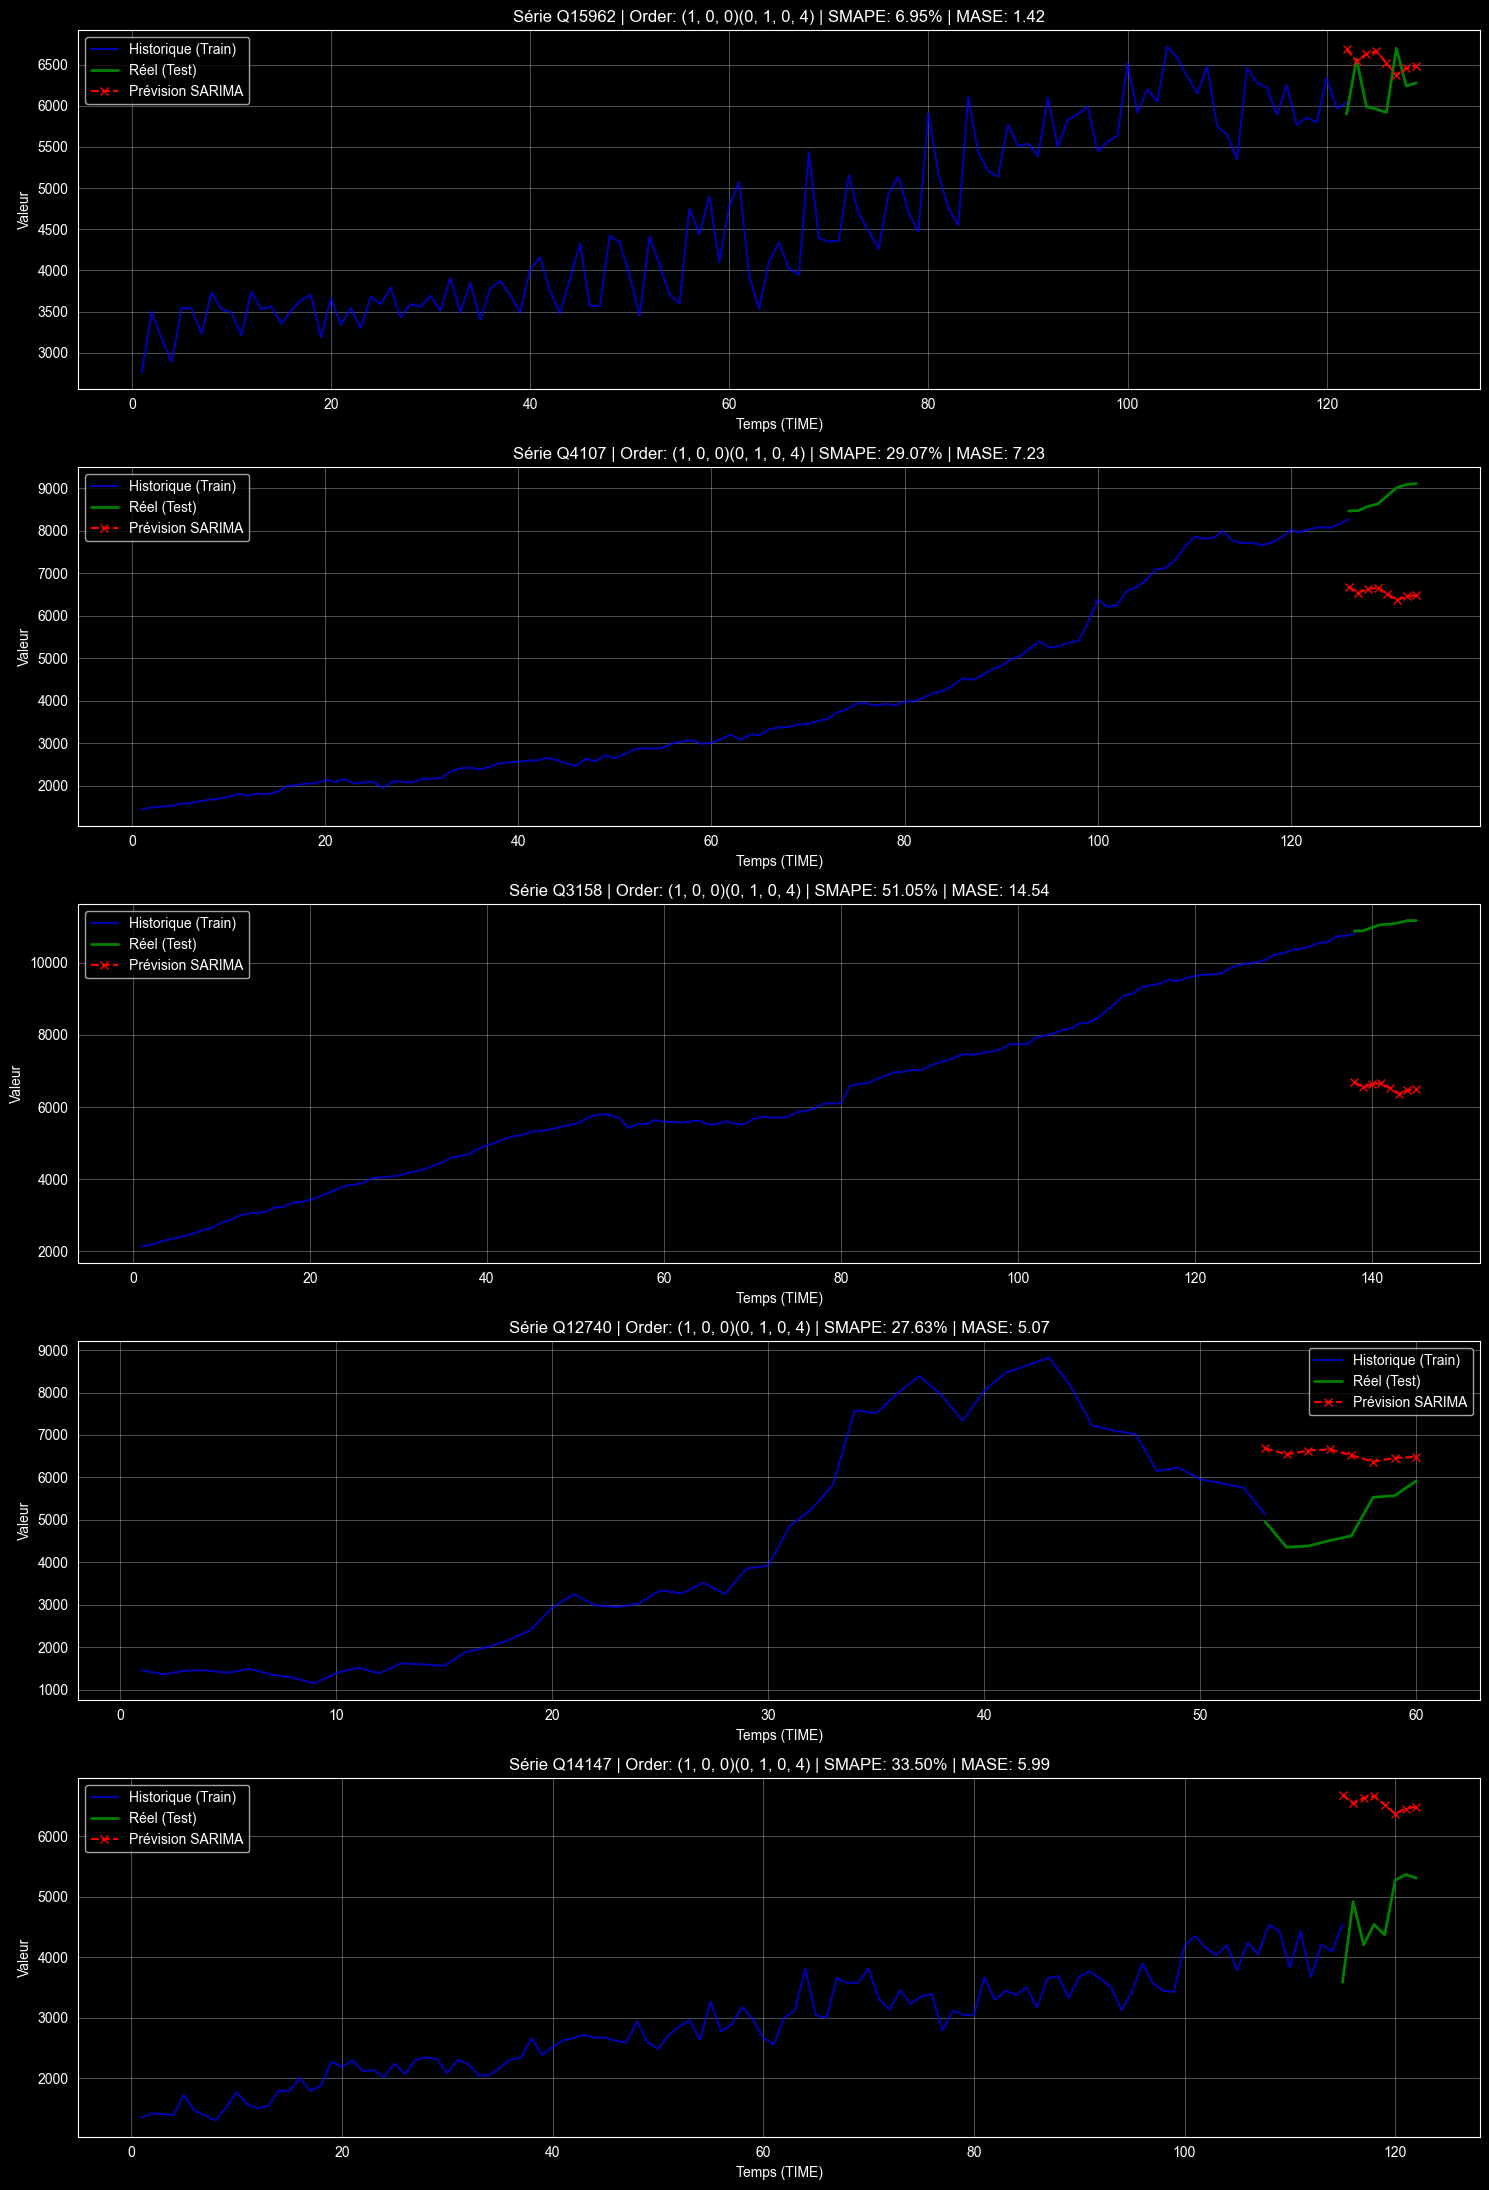

In [30]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

results = []
example_ids = np.random.choice(ids_100, size=5, replace=False)
fig, axes_list = plt.subplots(5, 1, figsize=(15, 22))
ax_map = {sid: ax for sid, ax in zip(example_ids, axes_list)}

for serie_id in ids_100:
    tr = data_clean[data_clean['ID'] == serie_id].sort_values("TIME")
    serie_train = tr['VALUE']
    x_train = tr['TIME']

    te = data_clean_test[data_clean_test['ID'] == serie_id].sort_values("TIME")
    y_test = te["VALUE"]
    x_test = te["TIME"]


    model_auto = auto_arima(serie,
                            seasonal=True, m=4, stepwise=True, suppress_warnings=True, error_action="ignore", start_P=1, D=1)

    p, d, q = model_auto.order

    y_pred = model_auto.predict(n_periods=len(y_test))
    sm = smape(y_test, y_pred)
    ms = mase(y_test, y_pred, serie)

    results.append({
        "ID": serie_id,
        "order": model_auto.order,
        "AIC": model_auto.aic(),
        "SMAPE": sm,
        "MASE": ms
    })

    if serie_id in example_ids:
            ax = ax_map[serie_id]
            ax.plot(x_train, serie_train, label="Historique (Train)", color="blue", alpha=0.7)
            ax.plot(range(len(x_train), len(x_train)+len(y_test)), y_test, label="Réel (Test)", color="green", linewidth=2)
            ax.plot(range(len(x_train), len(x_train)+len(y_pred)), y_pred, label="Prévision SARIMA", color="red", linestyle="--", marker='x')

            ax.set_title(f"Série {serie_id} | Order: {model_auto.order}{model_auto.seasonal_order} | SMAPE: {sm:.2f}% | MASE: {ms:.2f}")
            ax.set_xlabel("Temps (TIME)")
            ax.set_ylabel("Valeur")
            ax.legend()
            ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
results_df = pd.DataFrame(results)
results_df.head()

,ID,order,AIC,SMAPE,MASE
0,Q12799,"(1, 0, 0)",300.310813,35.310250,9.107280
1,Q5209,"(1, 0, 0)",300.310813,15.896679,3.089262
2,Q4122,"(1, 0, 0)",300.310813,115.996916,15.579688
3,Q7704,"(1, 0, 0)",300.310813,96.326690,13.791758
4,Q7118,"(1, 0, 0)",300.310813,39.036197,6.767986


In [32]:
print(f"SMAPE global SARIMA : {results_df['SMAPE'].mean()}")
print(f"MASE global SARIMA : {results_df['MASE'].mean()}")

SMAPE global SARIMA : 68.50420755415539
MASE global SARIMA : 13.33485662244178


En observant les métriques on peut comprendre pourquoi initialement auto ARIMA ne voulait pas utiliser la saisonnalité, les différences de résultats sont minimes et le cout de calcul supplémentaire n'est pas justifié.

# Machine Learning

Nous pouvons maintenant passer au machine learning

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LAGS = 8
DIFF = True

Nous définissons maintenant une fonction qui nous permet de récupérer les valeurs nécessaires aux modèles soit les lags que nous décidons d'utiliser et le trimestre de départ.

In [34]:
def make_ml_dataset(df, lags=8, diff=False):
    """
    Transforme le dataset long (ID, TIME, VALUE) en dataset supervisé (X, y)
    pour entraîner un modèle ML global sur toutes les séries.

    X = [lag_1..lag_8, Q_1..Q_4]
    y = VALUE (ou variation si diff=True)

    Note: les premières lignes de chaque série n'ont pas assez d'historique (lags),
    elles sont donc supprimées.
    """
    df_c = df.sort_values(["ID", "TIME"]).copy()

    # 1) Création de la cible et des retards (lags)
    if diff:
        df_c["target"] = df_c.groupby("ID")["VALUE"].diff()
        for k in range(1, lags + 1):
            df_c[f"lag_{k}"] = df_c.groupby("ID")["target"].shift(k)
    else:
        df_c["target"] = df_c["VALUE"]
        for k in range(1, lags + 1):
            df_c[f"lag_{k}"] = df_c.groupby("ID")["VALUE"].shift(k)

    # 2) Feature saisonnière (Quarterly -> 4 trimestres)
    df_c["quarter"] = ((df_c["TIME"] - 1) % 4 + 1).astype(int)

    # One-hot encoding du trimestre (Q_1, Q_2, Q_3, Q_4)
    df_c = pd.get_dummies(df_c, columns=["quarter"], prefix="Q")

    # 3) Liste des features utilisées (on filtre les colonnes créées)
    feature_cols = [c for c in df_c.columns if c.startswith("lag_") or c.startswith("Q_")]

    # 4) Suppression des lignes où il manque un lag (au début des séries)
    # On ajoute "target" dans le dropna pour enlever le premier point après un .diff()
    df_c = df_c.dropna(subset=feature_cols + ["target"])

    # 5) Matrice X et cible y
    X = df_c[feature_cols]
    y = df_c["target"]

    return X, y, feature_cols

Nous créons maintenant un dataset supervisé dans lequel chaque ligne correspond à une série.

In [35]:
# Construction du dataset supervisé global à partir de toutes les séries (train)
# lags=8 : correspond à 8 trimestres = 2 années de mémoire
X_train, y_train, feature_cols = make_ml_dataset(data_clean, lags=LAGS, diff=DIFF)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Nombre de features:", len(feature_cols))
print(X_train.head())


X_train shape: (1998108, 12)
y_train shape: (1998108,)
Nombre de features: 12
         lag_1       lag_2       lag_3       lag_4       lag_5       lag_6  \
9  -160.327463  326.185973 -108.657092   32.839847  258.493141   20.805623   
10  145.859760 -160.327463  326.185973 -108.657092   32.839847  258.493141   
11 -317.797744  145.859760 -160.327463  326.185973 -108.657092   32.839847   
12  -45.418346 -317.797744  145.859760 -160.327463  326.185973 -108.657092   
13 -194.846988  -45.418346 -317.797744  145.859760 -160.327463  326.185973   

         lag_7       lag_8    Q_1    Q_2    Q_3    Q_4  
9  -153.856849  121.153760  False   True  False  False  
10   20.805623 -153.856849  False  False   True  False  
11  258.493141   20.805623  False  False  False   True  
12   32.839847  258.493141   True  False  False  False  
13 -108.657092   32.839847  False   True  False  False  


Nous prenons un échantillon de 50000 séries pour entrainer nos modèles. Nous avons choisi ce nombre car il donne de meilleurs résultats qu'un échantillon plus petit mais utilise un temps d'entrainement toujours réalisable.

In [36]:
X_sample = X_train.sample(50000, random_state=42)
y_sample = y_train.loc[X_sample.index]
print("X_train shape:", X_sample.shape)
print("y_train shape:", y_sample.shape)

X_train shape: (50000, 12)
y_train shape: (50000,)


In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


Les models que nous avons choisi sont ceux demandé : Random forest et Gradient boosting

In [38]:
models = {

    "RandomForest": RandomForestRegressor(
        n_estimators=150,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}


In [39]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_sample, y_sample)


Training RandomForest...
Training GradientBoosting...


Nous définissons maintenant la fonction de prédiction.

Cette fonction est récursive car on ajoute la valeur qui vient d'être prédite à l'historique utilisé pour prédire la prochaine variable.

Ainsi à chaque pas on décale les lags d'un cran en ajoutant cette nouvelle valeur.

Il est également nécessaire de recréer les valeurs lors de l'utilisation d'un dataset différencié, pour cela on ajoute à la dernière valeur connue le résultat de la prédiction ce qui nous donne la nouvelle valeur prédite.

In [40]:
def forecast_ml(model, serie_values, feature_cols, h=8, lags=8, diff = False):
    """
    Prévision récursive sur h pas (multi-step).

    On prédit y_{t+1}, puis on l'ajoute à l'historique, puis on prédit y_{t+2}, etc.
    Cela permet de générer une suite de valeurs futures.

    serie_values : historique train (array)
    """
    serie = list(np.asarray(serie_values, dtype=float))

    if diff:
        history = list(np.diff(serie))
    else:
        history = list(serie)

    preds = []
    for step in range(1, h + 1):
        t = len(serie) + 1
        quarter = (t - 1) % 4 + 1
        features = {}

        for k in range(1, lags + 1):
            features[f"lag_{k}"] = history[-k]

        for q in [1, 2, 3, 4]:
            features[f"Q_{q}"] = 1 if quarter == q else 0

        X_new = pd.DataFrame([features])[feature_cols]
        y_pred = model.predict(X_new)[0]

        if diff:
            next_val = serie[-1] + y_pred
            preds.append(next_val)
            serie.append(next_val)
            history.append(y_pred)
        else:
            preds.append(y_pred)
            serie.append(y_pred)
            history.append(y_pred)

    return np.array(preds, dtype=float)


Nous exécutons à présent les deux modèles que nous avons choisis sur 100 séries choisies aléatoirement.

Pour chaque série on prédit les 8 prochaines valeurs puis on évalue la précision du modèle avec la méthode SMAPE et MASE

In [41]:
# IDs communs
ids_all = np.intersect1d(data_clean["ID"].unique(), data_clean_test["ID"].unique())

# Sample aléatoire de 100 séries
np.random.seed(42)
ids_eval = np.random.choice(ids_all, size=100, replace=False)

comparison_results = []

for name, model in models.items():
    results_model = []

    for serie_id in ids_eval:
        y_tr = (data_clean[data_clean["ID"] == serie_id]
                .sort_values("TIME")["VALUE"].values)

        y_te = (data_clean_test[data_clean_test["ID"] == serie_id]
                .sort_values("TIME")["VALUE"].values)

        y_hat = forecast_ml(model, y_tr, feature_cols, h=len(y_te), lags=LAGS, diff=DIFF)

        results_model.append({
            "SMAPE": smape(y_te, y_hat),
            "MASE": mase(y_te, y_hat, y_tr, m=4),
            "ID": serie_id,
        })

    df_res = pd.DataFrame(results_model)

    comparison_results.append({
        "Model": name,
        "SMAPE_global": df_res["SMAPE"].mean(),
        "MASE_global": df_res["MASE"].mean(),
        "Nb_series": len(df_res)
    })

comparison_df = pd.DataFrame(comparison_results).sort_values("SMAPE_global")
comparison_df


,Model,SMAPE_global,MASE_global,Nb_series
1,GradientBoosting,11.681472,1.456875,100
0,RandomForest,11.817171,1.482133,100


Avec entrainement sur l'ensemble des séries nous avons

| Model | SMAPE_global | MASE_global | Nb_series |
| --- | --- | --- | --- |
| GradientBoosting | 11.545728 | 1.441270 | 100 |
| RandomForest | 11.666665 | 1.431371 | 100 |

Ce qui signifie que GradientBoosting est plus précis que RandomForest par son SMAPE inférieur, mais cette différence est minime.

Néanmoins ces modèles sont tous deux moins précis que le modèle naif car leur MASE est supérieur à 1.


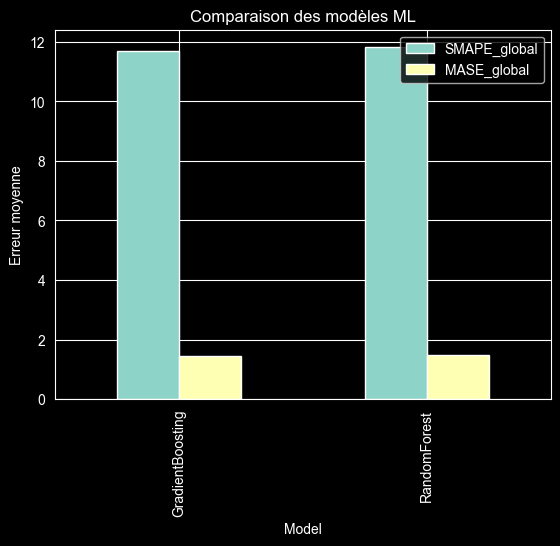

In [42]:
comparison_df.set_index("Model")[["SMAPE_global", "MASE_global"]].plot(kind="bar")
plt.title("Comparaison des modèles ML")
plt.ylabel("Erreur moyenne")
plt.show()


### Prédiction d'un série

Pour voir concrètement ce qui se passe quand on prédit et la marge d'erreur, nous avons prédit sur une seule série les prochaine valeurs.

In [43]:
serie_id = ids_eval[0]   # une série au hasard

y_train = (data_clean[data_clean["ID"] == serie_id]
           .sort_values("TIME")["VALUE"].values)
print("Longueur historique:", len(y_train))
print(serie_id)


Longueur historique: 92
Q12799


In [44]:
y_pred = forecast_ml(
    models["RandomForest"],
    y_train,
    feature_cols,
    h=8,
    lags=8,
    diff=True
)

print("Prévisions:", y_pred)
print(data_clean_test[data_clean_test["ID"] == serie_id].head())


Prévisions: [8996.24633039 9054.9877109  9155.11632887 9119.77478484 9138.94771796
 9178.85590249 9247.12923325 9250.84811384]
           ID  TIME        VALUE
24888  Q12799     1  8911.914138
24889  Q12799     2  9377.804176
24890  Q12799     3  9378.829833
24891  Q12799     4  9201.007813
24892  Q12799     5  9427.183997


# Deep Learning

Nous passons maintenant on deep learning nous allons tester deux modèles MLP et LSTM

In [45]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Nous créons d'abord les dataset de train et de test

In [46]:
# IDs communs train/test
ids_all = np.intersect1d(data_clean["ID"].unique(), data_clean_test["ID"].unique())

# Sample aléatoire de 100 séries
np.random.seed(42)
ids_100 = np.random.choice(ids_all, size=100, replace=False)

# Filtrer train/test
train_100 = data_clean[data_clean["ID"].isin(ids_100)].copy()
test_100  = data_clean_test[data_clean_test["ID"].isin(ids_100)].copy()

print("Train_100 shape:", train_100.shape)
print("Test_100 shape :", test_100.shape)


Train_100 shape: (9427, 3)
Test_100 shape : (800, 3)


In [47]:
def add_quarter(df):
    df = df.sort_values(["ID", "TIME"]).copy()
    df["quarter"] = ((df["TIME"] - 1) % 4 + 1).astype(int)  # 1..4
    return df

train_100 = add_quarter(train_100)
test_100  = add_quarter(test_100)


In [48]:
train_100.head()

,ID,TIME,VALUE,quarter
17871,Q1025,1,2670.0,1
17872,Q1025,2,2570.0,2
17873,Q1025,3,2480.0,3
17874,Q1025,4,2090.0,4
17875,Q1025,5,2360.0,1


On standardise VALUE sur le train (moyenne 0, variance 1), puis on applique la même transformation au test.

Nous avons essayé de d'entrainer le scaler sur chaque série séparément, mais cela donne des résultats inférieurs à la standardisation entrainée sur l'ensemble des séries

In [49]:
scaler = StandardScaler()
train_100["VALUE_S"] = scaler.fit_transform(train_100[["VALUE"]])
test_100["VALUE_S"]  = scaler.transform(test_100[["VALUE"]])

train_100.head()

,ID,TIME,VALUE,quarter,VALUE_S
17871,Q1025,1,2670.0,1,-0.465985
17872,Q1025,2,2570.0,2,-0.495416
17873,Q1025,3,2480.0,3,-0.521903
17874,Q1025,4,2090.0,4,-0.636681
17875,Q1025,5,2360.0,1,-0.557219


Comme précedement nous allons maintenant définir la méthode permettant de créer le dataset supervisé nécessaire aux algorithmes de deep learning.

On veut apprendre :(𝑦𝑡−8,...,𝑦𝑡−1)→𝑦𝑡(yt−8,...,yt−1)→yt	​
et on ajoute le trimestre de y_t (one-hot) comme feature.

In [50]:
def make_supervised_windows(df, window=8):
    """
    Construit un dataset global :
    X_seq : (N, window, 1)  -> séquence des 8 dernières valeurs
    X_q   : (N, 4)          -> quarter (one-hot) du point à prédire
    y     : (N,)            -> valeur à prédire (scaled)
    """
    X_seq, X_q, y = [], [], []

    for sid, g in df.groupby("ID"):
        g = g.sort_values("TIME")
        vals = g["VALUE_S"].values
        quarters = g["quarter"].values  # 1..4

        # on prédit à l'instant t, en utilisant les window valeurs avant t
        for t in range(window, len(vals)):
            past = vals[t-window:t]                 # taille window
            q_t = quarters[t]                       # quarter du point cible
            q_onehot = np.eye(4)[q_t - 1]           # 1..4 -> 0..3

            X_seq.append(past.reshape(window, 1))
            X_q.append(q_onehot)
            y.append(vals[t])

    return np.array(X_seq), np.array(X_q), np.array(y)

WINDOW = 8
X_seq, X_q, y = make_supervised_windows(train_100, window=WINDOW)

print("X_seq:", X_seq.shape)  # (N, 8, 1)
print("X_q  :", X_q.shape)    # (N, 4)
print("y    :", y.shape)


X_seq: (8627, 8, 1)
X_q  : (8627, 4)
y    : (8627,)


In [51]:
rng = np.random.RandomState(42)
idx = np.arange(len(y))
rng.shuffle(idx)

split = int(0.8 * len(y))
tr_idx, va_idx = idx[:split], idx[split:]

X_seq_tr, X_seq_va = X_seq[tr_idx], X_seq[va_idx]
X_q_tr,   X_q_va   = X_q[tr_idx],   X_q[va_idx]
y_tr,     y_va     = y[tr_idx],     y[va_idx]

print("Train:", X_seq_tr.shape, X_q_tr.shape, y_tr.shape)
print("Val  :", X_seq_va.shape, X_q_va.shape, y_va.shape)


Train: (6901, 8, 1) (6901, 4) (6901,)
Val  : (1726, 8, 1) (1726, 4) (1726,)


### MLP

Nous allons définir les différentes couches de notre modèle MLP.

Il sera composé de nos deux entrées (les sequence et leur trimestre).

Ces deux entrées seront aplatie puis combinée avant de passer par deux couches denses et enfin de récupérer la valeur prédite.

In [52]:
# Entrées
inp_seq = keras.Input(shape=(WINDOW, 1), name="seq")
inp_q   = keras.Input(shape=(4,), name="quarter")

# Aplatir la séquence (8 valeurs)
x = layers.Flatten()(inp_seq)

# Concaténer avec quarter
x = layers.Concatenate()([x, inp_q])

# Couches denses
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(1, name="yhat")(x)

mlp = keras.Model(inputs=[inp_seq, inp_q], outputs=out)
mlp.compile(optimizer="adam", loss="mse")

mlp.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 8, 1)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quarter             │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ quarter[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yhat (Dense)        │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_mlp = mlp.fit(
    {"seq": X_seq_tr, "quarter": X_q_tr}, y_tr,
    validation_data=({"seq": X_seq_va, "quarter": X_q_va}, y_va),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2967 - val_loss: 0.0925
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0643 - val_loss: 0.0585
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - val_loss: 0.0515
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - val_loss: 0.0473
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0444
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412 - val_loss: 0.0427
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.0422
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0415
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - val_loss: 0.0407
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369 - val_loss: 0.0390
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - val_loss: 0.0398
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362 - val_lo

MLP (Multi-Layer Perceptron)

Le MLP est un réseau de neurones entièrement connecté composé de couches d’entrée, cachées et de sortie.
Dans le cadre des séries temporelles, il ne traite pas directement la séquence complète, mais utilise une représentation supervisée basée sur des retards (lags).

Dans notre cas :(𝑦𝑡−8,...,𝑦𝑡−1)→𝑦𝑡(yt−8,...,yt−1)→yt
Les huit derniers trimestres sont utilisés pour prédire la valeur suivante.

Points clés

Introduit de la non-linéarité.

Capture des interactions complexes entre les retards.

Simple et rapide à entraîner.

Limite principale

Le MLP ne possède pas de mémoire temporelle interne.
Il traite les retards comme des variables indépendantes et ne capture pas explicitement les dépendances longues.

### LSTM

Nous définissons également un modèle LSTM qui contient les deux mêmes entrées, une couche LSTM et une couche dense.

In [54]:
inp_seq = keras.Input(shape=(WINDOW, 1), name="seq")
inp_q   = keras.Input(shape=(4,), name="quarter")

x = layers.LSTM(32)(inp_seq)                 # mémoire temporelle
x = layers.Concatenate()([x, inp_q])          # ajouter trimestre
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(1, name="yhat")(x)

lstm = keras.Model(inputs=[inp_seq, inp_q], outputs=out)
lstm.compile(optimizer="adam", loss="mse")

lstm.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 8, 1)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │      4,352 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quarter             │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 36)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ quarter[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,184 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yhat (Dense)        │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,569 (21.75 KB)

 Trainable params: 5,569 (21.75 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history_lstm = lstm.fit(
    {"seq": X_seq_tr, "quarter": X_q_tr}, y_tr,
    validation_data=({"seq": X_seq_va, "quarter": X_q_va}, y_va),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6732 - val_loss: 0.2397
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1437 - val_loss: 0.1027
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0919 - val_loss: 0.0816
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0732 - val_loss: 0.0690
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0620 - val_loss: 0.0602


LSTM (Long Short-Term Memory)

Les LSTM sont des réseaux récurrents conçus pour modéliser les dépendances temporelles longues.
Ils utilisent une cellule mémoire contrôlée par trois portes :

Porte d’oubli

Porte d’entrée

Porte de sortie

Ces mécanismes permettent de conserver les informations pertinentes et d’ignorer le bruit.

Dans notre implémentation

Fenêtre d’entrée : 8 trimestres

Couche LSTM (32 unités)

Couche Dense

Sortie linéaire

Ajout du trimestre via encodage one-hot

Le LSTM traite explicitement les données comme une séquence et peut théoriquement mieux modéliser la saisonnalité et la tendance.

Et enfin nous définissons la méthode de prédiction comme précédemment.

In [56]:
def forecast_dl_recursive(model, y_hist_scaled, start_time, h=8, window=8):
    """
    y_hist_scaled : historique train en échelle standardisée
    start_time    : dernier TIME du train (ex: len(y_train))
    h             : horizon
    """
    hist = list(np.asarray(y_hist_scaled, dtype=float))
    preds = []

    for step in range(1, h+1):
        t = start_time + step
        quarter = (t - 1) % 4 + 1
        q_onehot = np.eye(4)[quarter - 1]

        x_seq = np.array(hist[-window:]).reshape(1, window, 1)
        x_q = q_onehot.reshape(1, 4)

        yhat = model.predict({"seq": x_seq, "quarter": x_q}, verbose=0).ravel()[0]
        preds.append(yhat)
        hist.append(yhat)

    return np.array(preds)


Finalement, nous exécutons les prédictions sur 100 séries et évaluons leurs résultats.

In [57]:
def evaluate_model_dl(model, train_df, test_df, window=8):
    rows = []

    for sid in ids_100:
        g_tr = train_df[train_df["ID"] == sid].sort_values("TIME")
        g_te = test_df[test_df["ID"] == sid].sort_values("TIME")

        y_tr = g_tr["VALUE"].values
        y_te = g_te["VALUE"].values

        y_tr_s = g_tr["VALUE_S"].values
        h = len(y_te)
        if h == 0 or len(y_tr) < window + 4:
            continue

        start_time = int(g_tr["TIME"].max())
        yhat_s = forecast_dl_recursive(model, y_tr_s, start_time=start_time, h=h, window=window)

        # inverse scaling -> revenir en valeurs originales
        yhat = scaler.inverse_transform(yhat_s.reshape(-1, 1)).ravel()

        rows.append({
            "ID": sid,
            "SMAPE": smape(y_te, yhat),
            "MASE": mase(y_te, yhat, y_tr, m=4)
        })

    res = pd.DataFrame(rows)
    return res

res_mlp  = evaluate_model_dl(mlp,  train_100, test_100, window=WINDOW)
res_lstm = evaluate_model_dl(lstm, train_100, test_100, window=WINDOW)

print("MLP  -> SMAPE:", round(res_mlp["SMAPE"].mean(), 3), "MASE:", round(res_mlp["MASE"].mean(), 3))
print("LSTM -> SMAPE:", round(res_lstm["SMAPE"].mean(), 3), "MASE:", round(res_lstm["MASE"].mean(), 3))


MLP  -> SMAPE: 12.483 MASE: 1.682
LSTM -> SMAPE: 35.782 MASE: 6.493


Le modèle MLP est donc nettement plus performant que le modèle LSTM qui est deux fois moins performant que MLP de par les métriques utilisées.

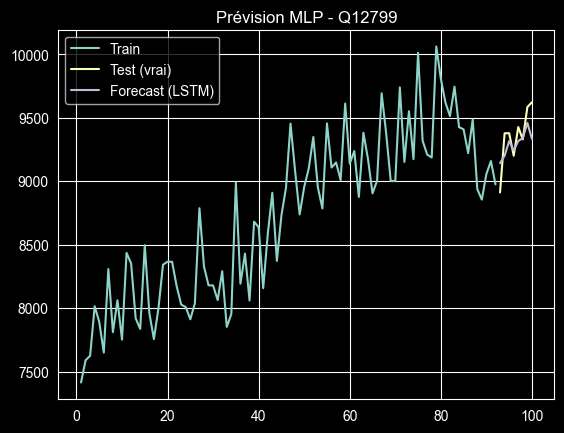

,y_test,y_pred_mlp
0,8911.914138,9142.113281
1,9377.804176,9200.941406
2,9378.829833,9316.653320
3,9201.007813,9243.234375
4,9427.183997,9316.603516
5,9329.258110,9340.754883
6,9584.655638,9460.083984
7,9622.622899,9334.444336


In [58]:
sid = ids_100[0]

g_tr = train_100[train_100["ID"] == sid].sort_values("TIME")
g_te = test_100[test_100["ID"] == sid].sort_values("TIME")

y_tr = g_tr["VALUE"].values
y_te = g_te["VALUE"].values
y_tr_s = g_tr["VALUE_S"].values
h = len(y_te)

start_time = int(g_tr["TIME"].max())

# Exemple : prédictions MLP
yhat_s = forecast_dl_recursive(mlp, y_tr_s, start_time=start_time, h=h, window=WINDOW)
yhat = scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()

t_tr = np.arange(1, len(y_tr)+1)
t_te = np.arange(len(y_tr)+1, len(y_tr)+h+1)

plt.figure()
plt.plot(t_tr, y_tr, label="Train")
plt.plot(t_te, y_te, label="Test (vrai)")
plt.plot(t_te, yhat, label="Forecast (LSTM)")
plt.title(f"Prévision MLP - {sid}")
plt.legend()
plt.show()

pd.DataFrame({"y_test": y_te, "y_pred_mlp": yhat})


Avantages et limites
MLP

✔ Simple et rapide
✔ Capture des non-linéarités
✘ Pas de mémoire temporelle
✘ Difficulté avec dépendances longues

LSTM

✔ Mémoire temporelle
✔ Capture dépendances longues
✘ Besoin important de données
✘ Entraînement plus coûteux
✘ Gain limité sur séries courtes

Les modèles de deep learning (MLP et LSTM) ont été implémentés afin de capturer des dépendances non linéaires et temporelles.
Le MSP obtient le meilleur SMAPE (13.57%), ce score reste inférieur à celui obtenu par le modèle Gradient boosting, les modèles de deep learning sont donc eux aussi inférieur au modèle naif dans notre cas.

Ces résultats montrent que sur des séries trimestrielles courtes, les modèles classiques et d’ensemble peuvent surpasser les architectures profondes plus complexes.

Les modèles de deep learning permettent d’introduire des structures non linéaires et séquentielles dans la prévision des séries temporelles.

Cependant, dans le cas des séries trimestrielles courtes du dataset M4, leurs performances restent comparables — voire légèrement inférieures en termes de robustesse — aux modèles d’ensemble classiques.

**La complexité du modèle doit être adaptée à la taille et à la structure des données**

# Transformer

In [59]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Encore une fois nous prenons 100 séries

In [60]:
# IDs communs train/test
ids_all = np.intersect1d(data_clean["ID"].unique(), data_clean_test["ID"].unique())

np.random.seed(42)
ids_100 = np.random.choice(ids_all, size=100, replace=False)

train_100 = data_clean[data_clean["ID"].isin(ids_100)].copy()
test_100  = data_clean_test[data_clean_test["ID"].isin(ids_100)].copy()

train_100 = train_100.sort_values(["ID", "TIME"])
test_100  = test_100.sort_values(["ID", "TIME"])

print("Train_100:", train_100.shape)
print("Test_100 :", test_100.shape)


Train_100: (9427, 3)
Test_100 : (800, 3)


Les Transformers (comme la plupart des réseaux) convergent mieux lorsque les données sont normalisées. On apprend un StandardScaler sur le train et on applique la même transformation au test.

In [61]:
scaler = StandardScaler()
train_100["VALUE_S"] = scaler.fit_transform(train_100[["VALUE"]])
test_100["VALUE_S"]  = scaler.transform(test_100[["VALUE"]])


On reformule la prévision en problème séquence→séquence : à partir d’une fenêtre passée de longueur L, le modèle prédit directement les H valeurs futures. Cette approche évite l’erreur accumulée des prévisions récursives.

In [62]:
L = 16  # longueur fenêtre entrée
H = 8   # horizon de prévision (Quarterly M4)

def build_windows_per_series(train_df, test_df, L=16, H=8):
    """
    Pour chaque série ID :
    - on prend la séquence train (scaled)
    - on construit une fenêtre X = derniers L points
    - la cible Y = les H points du test (scaled)

    On fait 1 exemple par série (direct multi-horizon).
    """
    X_list, Y_list, sid_list = [], [], []

    for sid in ids_100:
        tr = train_df[train_df["ID"] == sid].sort_values("TIME")
        te = test_df[test_df["ID"] == sid].sort_values("TIME")

        x = tr["VALUE_S"].values
        y = te["VALUE_S"].values

        if len(y) == 0:
            continue
        if len(x) < L:
            continue
        if len(y) != H:
            # normalement H=8 pour quarterly; si différent on ignore
            continue

        X_list.append(x[-L:].reshape(L, 1))   # (L,1)
        Y_list.append(y.reshape(H, 1))        # (H,1)
        sid_list.append(sid)

    return np.array(X_list), np.array(Y_list), np.array(sid_list)

X_np, Y_np, sids_np = build_windows_per_series(train_100, test_100, L=L, H=H)
print("X:", X_np.shape, "Y:", Y_np.shape, "Nb séries:", len(sids_np))


X: (100, 16, 1) Y: (100, 8, 1) Nb séries: 100


On encapsule les fenêtres (X,Y) dans un Dataset PyTorch, puis on utilise un DataLoader pour entraîner par mini-batch.

In [63]:
class Seq2SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N,L,1)
        self.Y = torch.tensor(Y, dtype=torch.float32)  # (N,H,1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# split train/val simple
rng = np.random.RandomState(42)
idx = np.arange(len(X_np))
rng.shuffle(idx)

split = int(0.8 * len(idx))
tr_idx, va_idx = idx[:split], idx[split:]

ds_tr = Seq2SeqDataset(X_np[tr_idx], Y_np[tr_idx])
ds_va = Seq2SeqDataset(X_np[va_idx], Y_np[va_idx])

dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True)
dl_va = DataLoader(ds_va, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

Le Transformer n’a pas de notion intrinsèque d’ordre temporel. On ajoute donc un encodage positionnel pour informer le modèle de la position de chaque observation dans la fenêtre.

In [64]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1,max_len,d_model)

    def forward(self, x):
        # x: (B,L,d_model)
        return x + self.pe[:, :x.size(1), :]


Nous utilisons un Transformer Encoder (self-attention) pour encoder la fenêtre passée. La sortie est ensuite projetée vers un vecteur de H valeurs futures (prévision directe multi-horizon).

In [65]:
class TransformerForecaster(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2, dim_ff=64, dropout=0.1, L=16, H=8):
        super().__init__()
        self.L, self.H = L, H
        self.input_proj = nn.Linear(1, d_model)
        self.posenc = PositionalEncoding(d_model, max_len=512)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff, dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # pooling + head multi-horizon
        self.pool = nn.AdaptiveAvgPool1d(1)  # moyenne sur le temps
        self.head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, H)  # H sorties (scaled)
        )

    def forward(self, x):
        # x: (B,L,1)
        z = self.input_proj(x)         # (B,L,d_model)
        z = self.posenc(z)             # + positional encoding
        z = self.encoder(z)            # (B,L,d_model)

        # pooling temporel : (B,d_model)
        z = z.transpose(1, 2)          # (B,d_model,L)
        z = self.pool(z).squeeze(-1)   # (B,d_model)

        yhat = self.head(z)            # (B,H)
        return yhat


L’entraînement minimise l’erreur quadratique moyenne (MSE) entre les H valeurs prédites et les H valeurs réelles. Un early stopping est utilisé pour éviter le sur-apprentissage.

In [66]:
model = TransformerForecaster(d_model=32, nhead=4, num_layers=2, dim_ff=64, dropout=0.1, L=L, H=H).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def eval_loss(dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)               # (B,L,1)
            yb = yb.to(device).squeeze(-1)   # (B,H)
            pred = model(xb)                 # (B,H)
            loss = loss_fn(pred, yb)
            losses.append(loss.item())
    return float(np.mean(losses)) if losses else np.nan

best_val = np.inf
patience, wait = 8, 0

for epoch in range(1, 101):
    model.train()
    for xb, yb in dl_tr:
        xb = xb.to(device)
        yb = yb.to(device).squeeze(-1)  # (B,H)

        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()

    val = eval_loss(dl_va)
    print(f"Epoch {epoch:03d} | val_loss={val:.6f}")

    if val < best_val - 1e-6:
        best_val = val
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_state)


Epoch 001 | val_loss=3.399070
Epoch 002 | val_loss=3.117980
Epoch 003 | val_loss=2.866324
Epoch 004 | val_loss=2.637715
Epoch 005 | val_loss=2.443624
Epoch 006 | val_loss=2.286026
Epoch 007 | val_loss=2.162126
Epoch 008 | val_loss=2.042283
Epoch 009 | val_loss=1.913832
Epoch 010 | val_loss=1.791867
Epoch 011 | val_loss=1.684633
Epoch 012 | val_loss=1.595169
Epoch 013 | val_loss=1.492508
Epoch 014 | val_loss=1.374958
Epoch 015 | val_loss=1.307244
Epoch 016 | val_loss=1.266680
Epoch 017 | val_loss=1.266252
Epoch 018 | val_loss=1.192101
Epoch 019 | val_loss=1.174708
Epoch 020 | val_loss=1.091429
Epoch 021 | val_loss=1.085670
Epoch 022 | val_loss=1.102966
Epoch 023 | val_loss=1.072066
Epoch 024 | val_loss=0.981941
Epoch 025 | val_loss=0.885209
Epoch 026 | val_loss=0.982376
Epoch 027 | val_loss=1.052714
Epoch 028 | val_loss=0.968206
Epoch 029 | val_loss=0.779894
Epoch 030 | val_loss=0.864044
Epoch 031 | val_loss=0.818836
Epoch 032 | val_loss=0.805657
Epoch 033 | val_loss=0.911281
Epoch 034 

<All keys matched successfully>

Le modèle prédit directement un vecteur de taille H en échelle normalisée. On applique ensuite l’inverse du scaler pour obtenir les valeurs dans l’échelle originale.

In [67]:
def predict_one_series(sid):
    tr = train_100[train_100["ID"] == sid].sort_values("TIME")
    x = tr["VALUE_S"].values
    if len(x) < L:
        return None

    X_in = torch.tensor(x[-L:].reshape(1, L, 1), dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        yhat_s = model(X_in).cpu().numpy().ravel()  # (H,)
    yhat = scaler.inverse_transform(yhat_s.reshape(-1, 1)).ravel()
    return yhat

sid0 = sids_np[0]
y_pred = predict_one_series(sid0)
print("ID:", sid0)
print("Pred:", y_pred)


ID: Q12799
Pred: [ 9626.426  9727.6    9795.85  10011.815  9780.428  9995.073 10281.323
 10352.953]


On évalue la qualité des prévisions sur le test M4 (H=8) avec SMAPE et MASE (m=4). MASE compare le modèle à un naïf saisonnier (y_t ≈ y_{t-4}).

In [68]:


rows = []
for sid in sids_np:
    tr = train_100[train_100["ID"] == sid].sort_values("TIME")
    te = test_100[test_100["ID"] == sid].sort_values("TIME")

    y_tr = tr["VALUE"].values
    y_te = te["VALUE"].values
    if len(y_te) != H or len(y_tr) < L:
        continue

    y_hat = predict_one_series(sid)
    rows.append({
        "ID": sid,
        "SMAPE": smape(y_te, y_hat),
        "MASE": mase(y_te, y_hat, y_tr, m=4)
    })

res_tf = pd.DataFrame(rows)
print("Nb séries:", len(res_tf))
print("SMAPE global:", round(res_tf["SMAPE"].mean(), 3))
print("MASE global:", round(res_tf["MASE"].mean(), 3))
res_tf.head()


Nb séries: 100
SMAPE global: 15.14
MASE global: 2.24


,ID,SMAPE,MASE
0,Q12799,6.131901,2.118246
1,Q5209,10.080665,0.717412
2,Q4122,5.105805,0.882476
3,Q7704,16.822313,4.939377
4,Q7118,85.854159,5.086415


On visualise une série pour vérifier qualitativement si le Transformer suit la dynamique et la saisonnalité sur l’horizon H.

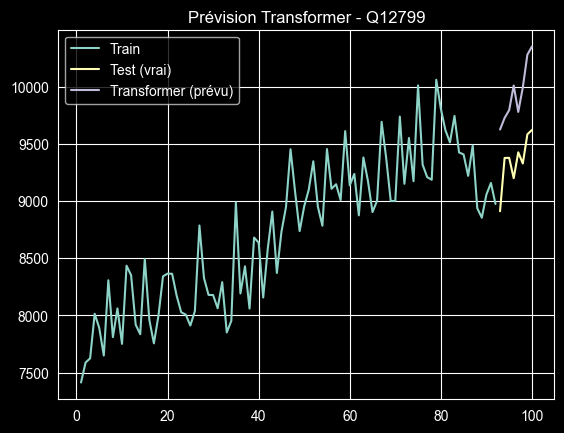

,y_test,y_pred_transformer
0,8911.914138,9626.425781
1,9377.804176,9727.599609
2,9378.829833,9795.849609
3,9201.007813,10011.815430
4,9427.183997,9780.427734
5,9329.258110,9995.073242
6,9584.655638,10281.323242
7,9622.622899,10352.953125


In [69]:
sid = sids_np[0]

tr = train_100[train_100["ID"] == sid].sort_values("TIME")
te = test_100[test_100["ID"] == sid].sort_values("TIME")

y_tr = tr["VALUE"].values
y_te = te["VALUE"].values
y_hat = predict_one_series(sid)

t_tr = np.arange(1, len(y_tr)+1)
t_te = np.arange(len(y_tr)+1, len(y_tr)+H+1)

plt.figure()
plt.plot(t_tr, y_tr, label="Train")
plt.plot(t_te, y_te, label="Test (vrai)")
plt.plot(t_te, y_hat, label="Transformer (prévu)")
plt.title(f"Prévision Transformer - {sid}")
plt.legend()
plt.show()

pd.DataFrame({"y_test": y_te, "y_pred_transformer": y_hat})


Le modèle Transformer a été implémenté dans une configuration séquence-à-séquence avec self-attention et encodage positionnel.
Toutefois, les performances obtenues (SMAPE = 15.064%, MASE = 2.059) sont inférieures à celles des modèles MLP et Gradient boosting.
Cette contre-performance peut s’expliquer par la faible longueur des séries trimestrielles du dataset M4, ainsi que par le nombre limité d’exemples d’entraînement disponibles pour le modèle global.
Les Transformers étant des architectures fortement paramétrées, ils nécessitent généralement des volumes de données plus importants et des séquences plus longues pour exprimer pleinement leur potentiel.

Le naïf saisonnier est un modèle de référence qui prédit chaque valeur future à partir de la valeur observée lors de la même période saisonnière précédente (ex : trimestre t ≈ trimestre t−4). Il constitue un benchmark simple mais souvent difficile à surpasser sur des séries saisonnières.

### Comparaison globale des modèles (100 séries Quarterly)

| Model | Type | SMAPE moyen (%) | MASE moyen   |
| --- | --- |-----------------|--------------|
| ARIMA | Statistique | 68.865311       | 13.506853    |
| SARIMA | Statistique | 68.5042   | 13.3348    |
| GradientBoosting (entraînement toutes observations) | Machine Learning | **11.545728**   | 1.441270     |
| RandomForest (entraînement toutes observations) | Machine Learning | 11.666665       | **1.431371** |
| GradientBoosting (entraînement 50000 observations) | Machine Learning | 11.681472       | 1.456875     |
| RandomForest (entraînement 50000 observations) | Machine Learning | 11.817171       | 1.482133     |
| MLP | Deep Learning | 13.344          | 1.883        |
| LSTM | Machine Learning | 47.118          | 11.606       |
| Transformer | Machine Learning | 13.084          | 1.864        |



Le MAPE mesure l’erreur moyenne en pourcentage entre les valeurs réelles et prédites.
Le MASE compare l’erreur du modèle à celle d’un modèle naïf saisonnier.
Un MASE inférieur à 1 indique que le modèle surpasse le benchmark naïf, tandis qu’un MASE supérieur à 1 signifie qu’il est moins performant que ce dernier.

Ce tableau met en évidence un constat intéressant : le modèle le plus complexe n’est pas forcément le plus performant.

Le Random Forest se distingue par la meilleure robustesse (MASE = 1.43). Cela signifie qu’il est globalement le plus fiable par rapport au benchmark naïf saisonnier. Il offre donc le meilleur compromis entre précision et stabilité.

Le Gradient Boosting, quant à lui, obtient le meilleur SMAPE (11.54%), ce qui montre qu’il capture légèrement mieux certaines variations locales. Cependant, son avantage reste modéré.

Quant à eux les modèles MLP, LSTM et Transformer, bien qu'étant des modèles de deep learning sont moins performant que les modèles de machine learning basique.